<a href="https://colab.research.google.com/github/guswns3396/PSYC-221-Project/blob/main/Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/PSYC221"

/content/drive/MyDrive/Colab Notebooks/PSYC221


In [3]:
!ls

brainmetshare-3


# Install & Import Dependencies

In [4]:
!pip install monai

In [5]:
import logging
import os
import sys
from glob import glob
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib

import monai
import monai.transforms as mt
from monai.data import Dataset, DataLoader
from monai.apps import CrossValidation

from monai.utils import set_determinism

import torch

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(seed=0)

# Get Data

In [7]:
IMG_TYPES = {
  'bravo': 0,
  'flair': 1,
  't1_gd': 2,
  't1_pre': 3
}

In [8]:
def get_data_dicts(path):
  data = [
    {
      'img': [os.path.join(subj, img_type + '.nii.gz') for img_type in IMG_TYPES],
      'seg': os.path.join(subj, 'seg.nii.gz')
    }
    for subj in glob(os.path.join(path, 'Mets_*'))
  ]
  return data

In [9]:
def fix_meta(data):
  """
  fix meta information of data after stacking
  """
  # fix img meta
  a = [data['img'].ndim, *data['img'].shape[1:], data['img'].shape[0]]
  for i, val in enumerate(a):
    data['img'].meta['dim'][i] = val
  data['img'].meta['original_channel_dim'] = -1
  # fix seg meta
  a = [data['seg'].ndim, *data['seg'].shape[1:], data['seg'].shape[0]]
  for i, val in enumerate(a):
    data['seg'].meta['dim'][i] = val
  data['seg'].meta['original_channel_dim'] = -1
  return data

In [10]:
def print_data(data):
  print(data['img'].shape)
  print(data['img'].meta)
  print(data['seg'].shape)
  print(data['seg'].meta)
  return data

In [11]:
path_train = 'brainmetshare-3/train'

In [12]:
data_dicts = get_data_dicts(path_train)

# Data Exploration

In [13]:
train_ds = Dataset(
  data_dicts,
  transform=mt.Compose([
    # load images
    mt.LoadImageD(['img', 'seg']),
  ])
)

# Load & Pre-Process Data

In [14]:
KEYS = ('img', 'seg')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

xform_train = mt.Compose([
  # load images
  mt.LoadImageD(KEYS),
  # make channel the first dimension / add channel dimension if necessary
  mt.EnsureChannelFirstD(KEYS),
  # fix meta
  fix_meta,
  # print data to ensure fix
  # print_data,
  # make sure tensor type
  mt.EnsureTypeD(keys=KEYS),
  # make sure all have same orientation (axcode)
  mt.Orientationd(keys=KEYS, axcodes="RAS"),
  mt.Spacingd(
      keys=KEYS,
      pixdim=(1.0, 1.0, 1.0),
      mode=("bilinear", "nearest"),
  ),
  # augment data to be invariant to orientation
  mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=0),
  mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=1),
  mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=2),
  # normalize intensity
  mt.NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
  # augment data to be invariant to intensity shift or scale
  mt.RandScaleIntensityd(keys="img", factors=0.1, prob=1.0),
  mt.RandShiftIntensityd(keys="img", offsets=0.1, prob=1.0),
  # convert to tensor & move to device
  mt.ToTensorD(keys=KEYS, device=device)
])

xform_val = mt.Compose([
  # load images
  mt.LoadImageD(KEYS),
  # make channel the first dimension / add channel dimension if necessary
  mt.EnsureChannelFirstD(KEYS),
  # fix meta
  fix_meta,
  # print data to ensure fix
  # print_data,
  # make sure tensor type
  mt.EnsureTypeD(keys=KEYS),
  # make sure all have same orientation (axcode)
  mt.Orientationd(keys=KEYS, axcodes="RAS"),
  mt.Spacingd(
      keys=KEYS,
      pixdim=(1.0, 1.0, 1.0),
      mode=("bilinear", "nearest"),
  ),
  # normalize intensity
  mt.NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
  # convert to tensor & move to device
  mt.ToTensorD(keys=KEYS, device=device)
])

Using device: cuda


In [15]:
class MRIDataset(ABC, Dataset):
    """
    Base class to generate cross validation datasets.
    """

    def __init__(
        self,
        data,
        transform,
        **kwargs
    ) -> None:
        data = self._split_datalist(datalist=data)
        super().__init__(data, transform, **kwargs)

    @abstractmethod
    def _split_datalist(self, datalist):
        raise NotImplementedError(f"Subclass {self.__class__.__name__} must implement this method.")

In [16]:
# k-fold cross validation
num = 5
folds = list(range(num))

cvdataset = CrossValidation(
    dataset_cls=MRIDataset,
    data=data_dicts,
    nfolds=num,
    seed=12345,
    transform=xform_train,
)

In [17]:
num_workers=0
batch_size=1

# get datasets
train_dss = [cvdataset.get_dataset(folds=folds[0:i] + folds[(i + 1) :]) for i in folds]
val_dss = [cvdataset.get_dataset(folds=i, transform=xform_val) for i in folds]

# get loaders & set batch size, number of workers, shuffle
train_loaders = [DataLoader(train_dss[i], batch_size=batch_size, shuffle=True, num_workers=num_workers) for i in folds]
val_loaders = [DataLoader(val_dss[i], batch_size=batch_size, num_workers=num_workers) for i in folds]

# Visualize Data

image shape: torch.Size([4, 240, 240, 150])
segment shape: torch.Size([1, 240, 240, 150])


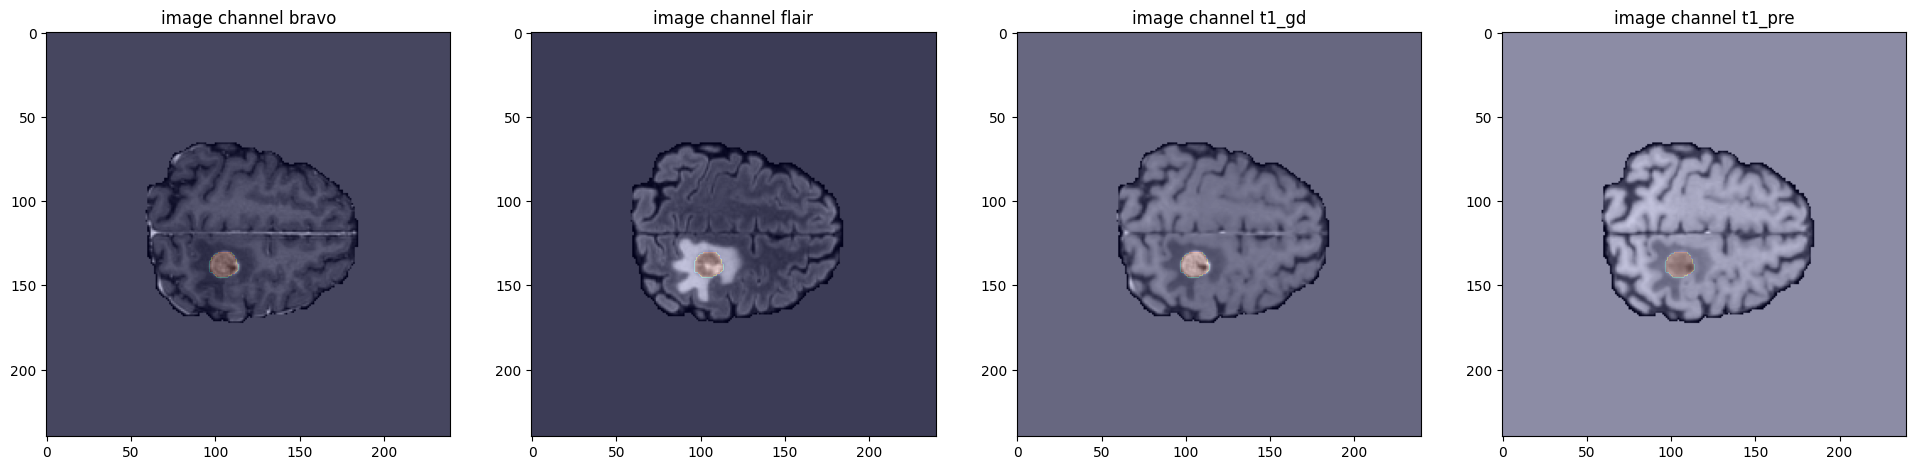

In [18]:
ds_idx = 0
subj_idx = 0

data = train_dss[ds_idx][subj_idx]
slice_id = np.argmax(data['seg'][0].sum(axis=[0,1])) # slice with most metastases

# visualize a slice from each image modality with segmentation overlay
print(f"image shape: {data['img'].shape}")
print(f"segment shape: {data['seg'].shape}")
plt.figure("image", (24, 6))
for i, img_type in enumerate(IMG_TYPES):
    plt.subplot(1, len(IMG_TYPES), i + 1)
    plt.title(f"image channel {img_type}")
    plt.imshow(data['img'][IMG_TYPES[img_type], :, :, slice_id].detach().cpu(),  cmap="gray")
    plt.imshow(data['seg'][0, :, :, slice_id].detach().cpu(), cmap='jet', alpha=0.2) # interpolation='none'
plt.show()

# Implement Model

In [18]:
net = monai.networks.nets.UNet(
    # 3D
    spatial_dims=3,
    # 4 modalities
    in_channels=4,

    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    kernel_size=3,
    up_kernel_size=3
    num_res_units=2,
    act='PRELU',
    norm=monai.networks.layers.Norm.BATCH,
    dropout=0,
    bias=True,
    adn_ordering='NDA'
).to(device)
loss = monai.losses.DiceLoss(sigmoid=True)
opt = torch.optim.Adam(net.parameters(), 1e-2)

# Training